In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
tf.executing_eagerly()

True

In [4]:
from tensorflow.keras.applications.vgg19 import VGG19

model = VGG19(
    include_top = False,
    weights = 'imagenet'
)
model.trainable = False
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [5]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [6]:
def load_process_img(img_path):
    img = load_img(img_path)
    img = img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis = 0)
    return img

def deprocess(arr):
    arr[:, :, 0] += 103.939
    arr[:, :, 1] += 116.779
    arr[:, :, 2] += 123.68
    arr = arr[:, :, ::-1]
    arr = np.clip(arr,0,255).astype('uint8')
    return arr

def display_image(image):
    if len(image.shape)== 4:
        img = np.squeeze(image, axis = 0)
    img = deprocess(img)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.real(img))
    plt.show()
    return

    
    

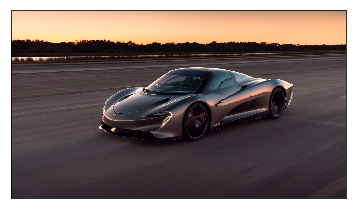

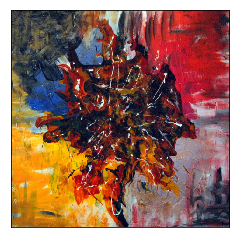

In [7]:
display_image(load_process_img('images/car.jpg'))
display_image(load_process_img('images/style.jpg'))

In [8]:
content_layer = 'block5_conv2'
style_layers = ['block1_conv1','block3_conv1','block5_conv1']

content_model = Model(
    inputs = model.input,
    outputs = model.get_layer(content_layer).output  
)
style_models =[Model(
    inputs = model.input,
    outputs = model.get_layer(layer).output) for layer in style_layers]

In [9]:
def content_cost(content, generated):
    activation_content = content_model(content)
    activation_generated = content_model(generated)
    cost = tf.reduce_mean(tf.square(activation_content - activation_generated))
    return cost

def gram_matrix(A):
    no_of_channels = int(A.shape[-1])
    a = tf.reshape(A,[-1,no_of_channels])
    num = tf.shape(a)[0]
    G = tf.matmul(a,a,transpose_a = True)
    return G/tf.cost(num,tf.float32)

lamb = 1.0/len(style_models)
def style_cost(style, generated):
    J_style = 0
    for style_model in style_models:
        activation_style = style_model(style)
        activation_generated = style_model(generated)
        gram_style = gram_matrix(activation_style)
        gram_generated = gram_matrix(activation_generated)
        current_cost = tf.reduce_mean(tf.square(gram_style - gram_generated))
        J_style += current_cost * lamb
    return J_style        

In [10]:
import time

In [11]:
generated_images = []
def loop(content_path,style_path,itr = 20, alpha = 15, beta = 25):
    content = load_process_img(content_path)
    style = load_process_img(style_path)
    generated = tf.Variable(content, dtype = tf.float32)
    opt = keras.optimizers.Adam(learning_rate=7.0)
    best_cost = 1e12+0.1
    best_image = None
    start_time = time.time()
    for i in range(itr):
        with tf.GradientTape() as tape:
            J_content = content_cost(content,generated)
            J_style = style_cost(style,generated)
            J_total = alpha*J_content + beta*J_style
        grads = tape.gradient(J_total.generated)
        opt.apply_gradients([(grads.generated)])
        if J_total < best_cost:
            best_cost = J_total
            best_image = generated.numpy()
        print("Cost {} : {} ,Time : {}".format(i,J_total,time.time()))
        generated_images.append(generated.numpy())
    return best_image

In [ ]:
best_image = loop('images/car.jpg','images/style.jpg')